In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [6]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')
predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store: 
    enrichment_complexes = store['/ptm_stats/joint_camera_complexes']
    joint_limma_stats = store['/ptm_stats/joint_limma_stats']
    

In [4]:
COMPLEXES_FOLD_CHANGE_THRESHOLD  = 0.25
VMIN = -1.5
VMAX = 1.5

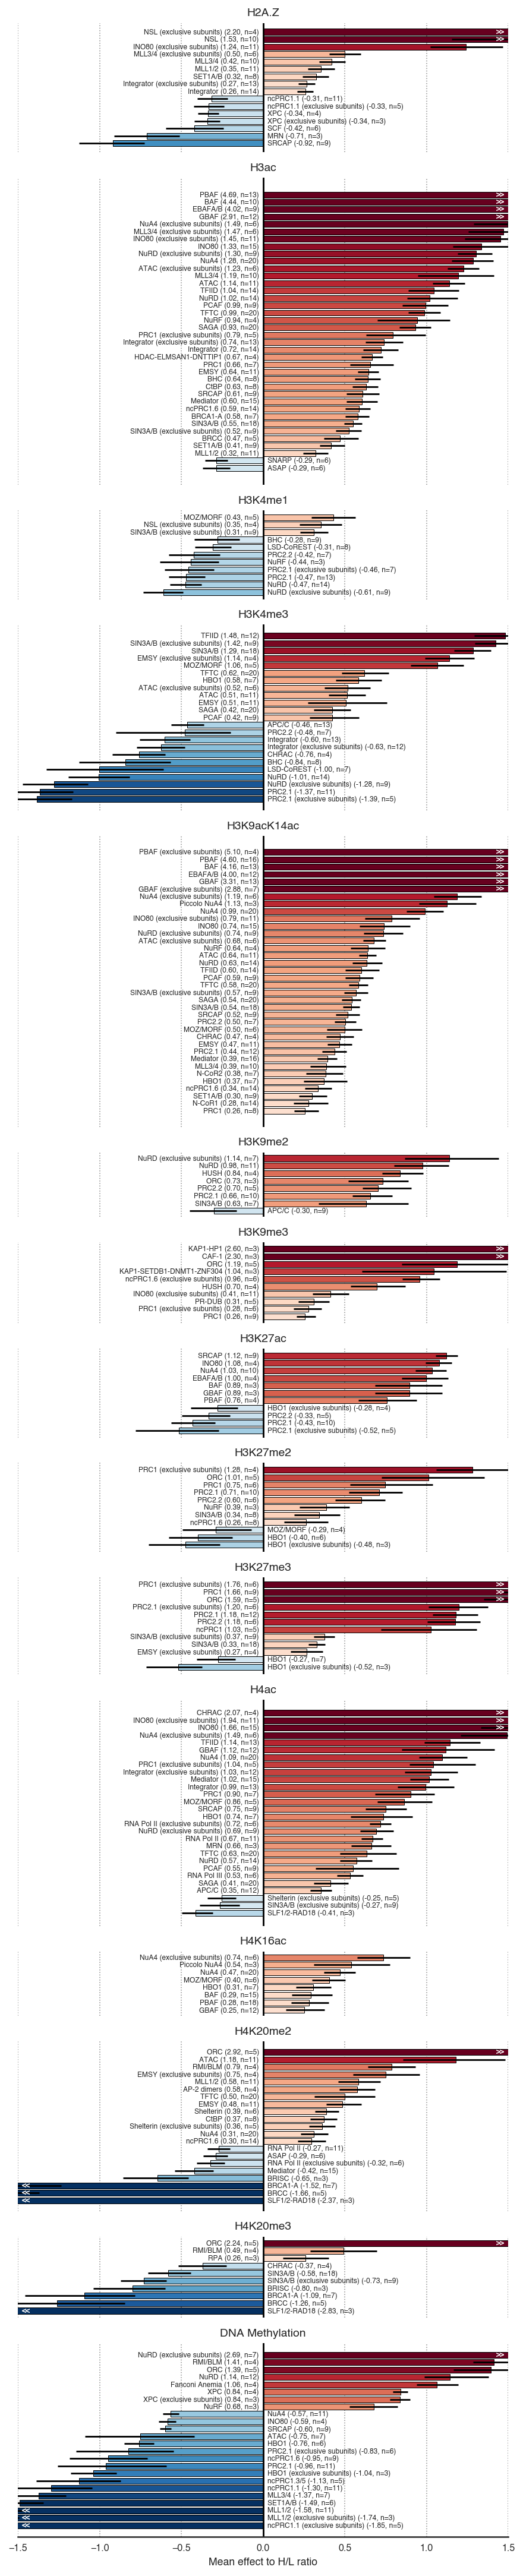

In [6]:
from matplotlib import gridspec
import matplotlib.colors

text_pos = 0.025
norm = matplotlib.colors.Normalize(VMIN, VMAX)
cmap = matplotlib.cm.RdBu_r

df_significant = enrichment_complexes.query('significant == True')
df_significant = df_significant[df_significant['empirical_median'].abs() >= COMPLEXES_FOLD_CHANGE_THRESHOLD]

size_ratios = []

for predictor in PREDICTOR_ORDER:
    size_ratios.append(len(df_significant.loc[predictor]))
    
fig = plt.figure(figsize=(6, 30), constrained_layout=True)

gs = gridspec.GridSpec(len(PREDICTOR_ORDER), 1, 
                       figure=fig, 
                       height_ratios=size_ratios)

ax = None
for i, predictor in enumerate(PREDICTOR_ORDER):
    ax = fig.add_subplot(gs[i, 0], sharex=ax)
    
    subdf = df_significant.loc[predictor]
    subdf = subdf.sort_values(by='empirical_median')
    
    
    coordinates = list(range(len(subdf)))
    mean_logFC = subdf['empirical_median']
    
    ci_left = subdf['empirical_median_ci_left']
    ci_right = subdf['empirical_median_ci_right']
    
    err_low = mean_logFC - ci_left
    err_high = ci_right - mean_logFC
    
    errorbars = []
    for ix in mean_logFC.index:
        errorbars.append([err_low.loc[ix], err_high.loc[ix]])
            
    index = subdf.index
    n_proteins = subdf['NGenes']
    fdrs = subdf['FDR']
    
    labels = []
    for ix in index:
        n_prot = int(n_proteins.loc[ix])
        fc = mean_logFC.loc[ix]
        labels.append(f'{ix} ({fc:.2f}, n={n_prot})')
    
    for (label, coord, fc) in zip(labels, coordinates, mean_logFC):
        
        left = fc < 0
        
        if left:
            ax.text(text_pos, coord, label, fontsize=6, ha='left', va='center')
            if fc < VMIN:
                ax.text(VMIN+text_pos, coord, '<<', fontweight='bold', fontsize=6, ha='left', color='white', va='center')
        else:
            if fc > VMAX:
                ax.text(VMAX-text_pos, coord, '>>', fontweight='bold', fontsize=6, ha='right', color='white', va='center')
            
            ax.text(-text_pos, coord, label, fontsize=6, ha='right', va='center')
    
    colors = [cmap(norm(fc)) for fc in mean_logFC]
    ax.barh(coordinates, mean_logFC, 
            xerr=np.atleast_2d(errorbars).T, 
            color=colors, edgecolor='black', linewidth=0.5)
    
    ax.axvline(0, linestyle='-', color='k')
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    ax.spines['left'].set_visible(False)
    
    if i != len(PREDICTOR_ORDER) - 1:
        for tick in ax.get_xticklabels():
            tick.set_visible(False)
            
        ax.spines['bottom'].set_visible(False)
    
    else:
        ax.set_xlabel('Mean effect to H/L ratio')
    
    ax.set_title(predictor)
    
ax.set_xlim(VMIN, VMAX)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'complexes-enrichment-barplot.pdf'))

In [7]:
df = enrichment_complexes

complexes_matrix = df['mean_logFC'].unstack('predictor')
complexes_significant = df['significant'].unstack('predictor')

complexes_matrix = complexes_matrix.reindex(predictors, axis=1)
complexes_significant = complexes_significant.reindex(predictors, axis=1).fillna(False)

keep = complexes_significant.any(axis=1)

COMPLEXES_FOLD_CHANGE_THRESHOLD  = 0.2
complexes_significant_with_fc = complexes_significant & (complexes_matrix.abs() >= COMPLEXES_FOLD_CHANGE_THRESHOLD)

keep_with_fc_threshold = complexes_significant_with_fc.any(axis=1)

complexes_matrix_with_fc = complexes_matrix[keep_with_fc_threshold]
complexes_significant_with_fc = complexes_significant_with_fc[keep_with_fc_threshold]

complexes_matrix = complexes_matrix.loc[keep]
complexes_significant = complexes_significant.loc[keep]

Note clustering below is based on absolute matrix!

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(os.path.join(OUTPUT_DIRECTORY, 'complexes-enrichment-protein-breakdown.pdf')) as pdf:
  
  for predictor in tqdm(predictors):
    ls = joint_limma_stats.loc[predictor]
    ec = enrichment_complexes.loc[predictor]
    ec = ec[ec['significant']]
    ec = ec[ec['mean_logFC'].abs() >= COMPLEXES_FOLD_CHANGE_THRESHOLD]
    
    if ec.empty:
        print(f'No complexes to plot for {predictor}')
        continue

    df = ec['mean_proteins'].str.split('/', expand=True).stack()
    df = df.reset_index()
    df.columns = ['Complex', 'i', 'Gene label']
    df = df.join(ls['logFC'], on='Gene label')

    matrix = df.set_index(['Complex', 'Gene label'])['logFC'].unstack('Gene label')
    
    row_cluster = len(matrix.index) > 1
    col_cluster = len(matrix.columns) > 1
    
    clustermap = sns.clustermap(matrix.fillna(0), mask=matrix.isnull(), 
                                center=0,
                                metric='euclidean', 
                                method='ward', 
                                figsize=(max(matrix.shape[1] * 0.2, 4), max(matrix.shape[0] * 0.2, 4)),
                                yticklabels=1,
                                xticklabels=1,
                                linewidth=1.0,
                                linecolor='k',
                                row_cluster=row_cluster,
                                col_cluster=col_cluster,
                                vmin=VMIN,
                                vmax=VMAX,
                                cmap='RdBu_r')

    clustermap.ax_heatmap.xaxis.set_tick_params(labelsize=8, length=0)
    clustermap.ax_heatmap.yaxis.set_tick_params(labelsize=8, length=0)
    clustermap.ax_col_dendrogram.set_title(predictor)
  
    pdf.savefig(bbox_inches='tight')
    plt.close()

100%|██████████| 15/15 [00:38<00:00,  2.25s/it]
